The challenge that this notebook is going to tackle is one of cancer detection. The goal of this notebook is to develop a machine learning model that will allow for an image to be binarily classified as having at least one pixel of tumor tissue in the central 32x32 pixel patch of the images. The solution outputted by this notebook will be a probability of each evaluation image’s central patch contains a metastasized tumor. 

The data that will be used in this assignment is a subset of PatchCamelyon dataset in which duplicate images have been removed. The data has been provided by the Kaggle challenge (https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) that is being submitted to for evaluation. These images consist of 96x96 pixel images used in histopathology to determine if metastasis has occurred. These images possess 3 color channels.

The data set that has been provided consists of 220,025 training images and of those training images, 89,117 are malignant and 130,908 are benign. Given this 41,791-sample disparity between the two classes, I could balance them by generating new additional malignant images or by reducing the number of benign images. These images will also be augmented using rotations and flips to add variation to the dataset.

As part of EDA, I outputted 9 malignant and 9 benign images to conduct a visual inspection of the data. This inspection showed that the images that are presented have a great variety in across both classes, with come cluttered and some sparce. The sheer variety of images leads me to believe that the proper method to develop a model would be a CNN. In the past we developed a model by merely vectorizing the MINST dataset. This method would be particularly useless as each image would present very differently from each other in a vectorized form. 

The architecture of this CNN was to have a series of repeating convolution 2d layers supplied by PyTorch followed by a Relu Activation layer and max pooling operation. The number of filters is additionally doubled each layer. After repeating this a few times, the features are then flattened and played thorough an additional Relu activation layer, dropout and soft activation output. The resulting neural net has a relatively small 166,522 parameters. The initial performace of this model was an 81% public score and a 77% private score over 25 epochs. 

Parameter tuning that occurred included the increase of epochs to 80 to give a clearer picture as to when the model’s validation accuracy was leveling off. The learning rate was additionally run multiple times in the range between .0005 - .0025. Additionally tuning included changing the size of the input images and adding and subtracting layers to the feature training. 

By implementing the above tuning, the model’s accuracy was able to increase to have an 89% private score and 91% public score which I think is an acceptable accuracy level for this model to achieve.  Additional improves that might be able to be used in this mode would be the incorporation of transfer learning by adding a pretrained model to the start. The only concern that this additional improvement would have is that since this is specialized medical data, preexisting models might not be well enough suited for this situation. Additionally, more complex models exceed the available computing sources. 




In [1]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import torch

import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils

In [2]:
import pandas as pd 
labels_df = pd.read_csv('./data/train_labels.csv')
label_counts = labels_df['label'].value_counts()
print(label_counts)

label
0    130908
1     89117
Name: count, dtype: int64


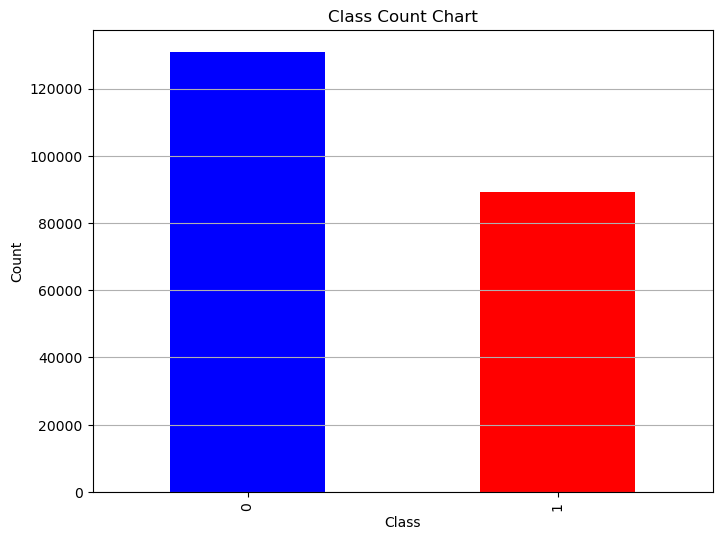

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red']) 
plt.title('Class Count Chart')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='-')
plt.show()

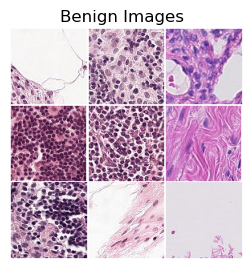

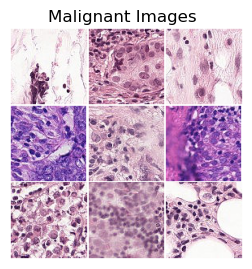

In [4]:
import os
from PIL import Image, ImageDraw
import numpy as np

def plot_image_grid(ids, title, nrows=3, ncols=3):
    fig, ax = plt.subplots(nrows, ncols, figsize=(3, 3))
    plt.subplots_adjust(wspace=0, hspace=0)

    for i, j in enumerate(ids[:nrows * ncols]):
        fname = os.path.join("./data/train/", j + '.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0, 0), (95, 95)), outline='white')
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

malignant_ids = labels_df.loc[labels_df['label']==1]['id'].values    # get the ids of malignant cases
benign_ids = labels_df.loc[labels_df['label']==0]['id'].values  
plot_image_grid(benign_ids, "Benign Images")
plot_image_grid(malignant_ids, "Malignant Images")
plt.show() 


In [5]:
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import numpy as np

class PyTorchData(Dataset):
    def __init__(self, data_dir, transform, data_type='train', sample_size=None):
        cdm_data = os.path.join(data_dir, data_type)
        file_names = os.listdir(cdm_data)
        if not sample_size:
            sample_size = len(file_names) 
            
        idx_choose = np.random.choice(np.arange(len(file_names)), sample_size, replace=False).tolist()
        file_names = [file_names[x] for x in idx_choose]

        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names]
        print(len(self.full_filenames))
        
        if data_type == "test":
            csv_filename = "sample_submission.csv"
            labels_data = os.path.join(data_dir, csv_filename)
        else:
            labels_data = os.path.join(data_dir, "train_labels.csv")

        labels_df = pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True)
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names]
        self.transform = transform
    
    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [6]:
import torchvision.transforms as transforms
image_size = 96
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((image_size,image_size))])

In [7]:
data_dir = './data/'
img_dataset = PyTorchData(data_dir, data_transformer, "train", sample_size = 100000)
train_ts, val_ts = random_split(img_dataset, [int(0.8*len(img_dataset)), len(img_dataset) - int(0.8*len(img_dataset))]) 

100000


In [8]:
# Define the following transformations for the training dataset
tr_transf = transforms.Compose([
#     transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
#     transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [9]:
from torch.utils.data import DataLoader
batch_size = 2560
# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=batch_size, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=batch_size,
                    shuffle=False)

In [10]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, params):
        super(Network, self).__init__()
        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.features = nn.Sequential(
            nn.Conv2d(Cin, init_f, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(init_f, 2 * init_f, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Compute the flatten size
        dummy_input = torch.randn(1, Cin, Hin, Win)
        self.num_flatten = self.features(dummy_input).view(-1).shape[0]

        self.classifier = nn.Sequential(
            nn.Linear(self.num_flatten, num_fc1),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(num_fc1, num_classes)
        )

    def forward(self, X):
        X = self.features(X)
        X = X.view(-1, self.num_flatten)
        X = self.classifier(X)
        return nn.functional.log_softmax(X, dim=1)


In [11]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,image_size,image_size), 
        "initial_filters": 10,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)
device = torch.device('cuda')
model = cnn_model.to(device)

In [12]:
from torchsummary import summary
summary(cnn_model, input_size=(3, image_size, image_size),device=device.type)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       280
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       1,820
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       7,240
|    └─ReLU: 2-8                         --
|    └─MaxPool2d: 2-9                    --
|    └─Conv2d: 2-10                      28,880
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-2                        --
|    └─Linear: 2-13                      128,100
|    └─ReLU: 2-14                        --
|    └─Dropout: 2-15                     --
|    └─Linear: 2-16                      202
Total params: 166,522
Trainable params: 166,522
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       280
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       1,820
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       7,240
|    └─ReLU: 2-8                         --
|    └─MaxPool2d: 2-9                    --
|    └─Conv2d: 2-10                      28,880
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-2                        --
|    └─Linear: 2-13                      128,100
|    └─ReLU: 2-14                        --
|    └─Dropout: 2-15                     --
|    └─Linear: 2-16                      202
Total params: 166,522
Trainable params: 166,522
Non-trainable params: 0

In [13]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
opt = optim.Adam(cnn_model.parameters(), lr=0.0004)

def get_lr(opt: optim.Optimizer) -> float:
    """Get the learning rate from the optimizer."""
    for param_group in opt.param_groups:
        return param_group['lr']

def loss_batch(loss_func: nn.Module, output: torch.Tensor, target: torch.Tensor, opt: optim.Optimizer = None) -> tuple:
    """Compute loss and metric for a batch of data."""
    loss = loss_func(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    metric_b = pred.eq(target.view_as(pred)).sum().item()

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model: nn.Module, loss_func: nn.Module, dataset_dl: DataLoader, opt: optim.Optimizer = None) -> tuple:
    """Compute loss and metric for the entire dataset (epoch)."""
    run_loss = 0.0
    t_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb, yb = xb.to(device), yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        run_loss += loss_b

        if metric_b is not None:
            t_metric += metric_b

    loss = run_loss / float(len_data)
    metric = t_metric / float(len_data)

    return loss, metric


In [14]:
import torch
import copy
from tqdm.notebook import tqdm

def train_val(model, params):
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]


    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in tqdm(range(epochs)):
        current_lr = get_lr(opt)

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "model.pt")

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            model.load_state_dict(best_model_wts)


    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history


In [15]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 80,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=0.0025),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='max',
                                factor=0.25,
                                patience=20,
                                ),
 "f_loss": nn.NLLLoss(reduction="sum"),
}
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/80 [00:00<?, ?it/s]

<Axes: >

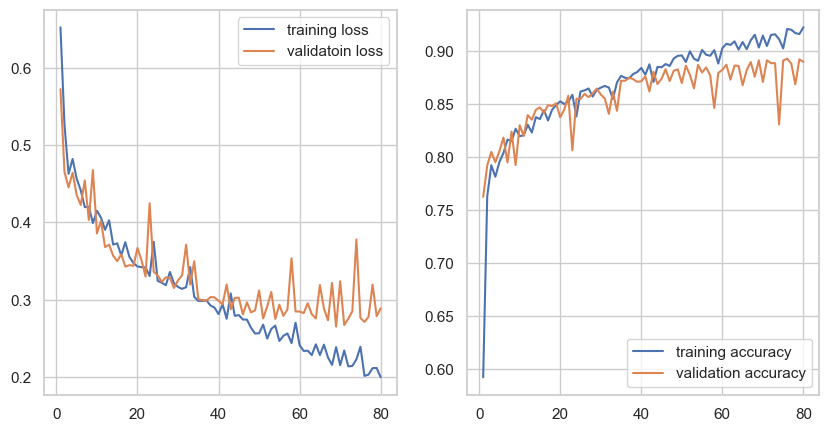

In [23]:
import seaborn as sns; 

sns.set(style='whitegrid')
fig,ax = plt.subplots(1,2,figsize=(10,5))

sns.lineplot(x=[*range(1,params_train["epochs"]+1)],y=loss_hist["train"],ax=ax[0],label='training loss')
sns.lineplot(x=[*range(1,params_train["epochs"]+1)],y=loss_hist["val"],ax=ax[0],label='validatoin loss')

sns.lineplot(x=[*range(1,params_train["epochs"]+1)],y=metric_hist["train"],ax=ax[1],label='training accuracy')
sns.lineplot(x=[*range(1,params_train["epochs"]+1)],y=metric_hist["val"],ax=ax[1],label='validation accuracy')

In [17]:
cnn_model.load_state_dict(torch.load('model.pt'))
img_dataset_test = PyTorchData(data_dir,data_transformer,data_type="test")

57458


In [18]:
def inference_and_save_csv(model, dataset, device, num_classes=2, output_csv="predictions.csv"):
    """
    Perform inference using a PyTorch model on a given dataset and save results to a CSV file.

    Args:
        model (nn.Module): The trained PyTorch model.
        dataset (Dataset): The dataset for inference.
        device (str): Device to move the model to (e.g., 'cuda' or 'cpu').
        num_classes (int, optional): Number of output classes. Defaults to 2.
        output_csv (str, optional): Path to save the CSV file. Defaults to "predictions.csv".
    """
    len_data = len(dataset)
    predictions = torch.zeros(len_data, num_classes)  # Initialize output tensor
    ground_truth = np.zeros(len_data, dtype="uint8")  # Initialize ground truth

    model = model.to(device)  # Move model to device

    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x, y = dataset[i]
            ground_truth[i] = y
            predictions[i] = model(x.unsqueeze(0).to(device))

    # Create a DataFrame with file names and predicted probabilities
    df = pd.DataFrame({
        "id": [f.split("\\")[-1][:-4] for f in dataset.full_filenames],
        "label": np.exp(predictions.numpy()[:, 1])  # Assuming binary classification
    })
    print(predictions[0:5])
    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
inference_and_save_csv(cnn_model,img_dataset_test, device) 

  0%|          | 0/57458 [00:00<?, ?it/s]

tensor([[-1.3925e-01, -2.0403e+00],
        [-4.8523e-01, -9.5595e-01],
        [-5.6156e-04, -7.4851e+00],
        [-4.1106e-02, -3.2121e+00],
        [-2.8435e+00, -5.9985e-02]])


Code References Used:
https://pytorch.org/docs/stable/nn.html
https://www.kaggle.com/code/loyumbamoirangthem/cancer-detection-with-pytorch/notebook
